# Trouton's Rule

In [31]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import constants
from scipy.stats import t
import seaborn as sns

## linear regression

In [2]:
def ols_slope(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sum((x - x_mean) ** 2)
    return numerator / denominator

def ols_intercept(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    slope = ols_slope(x, y)
    return y_mean - slope * x_mean

def ols(x, y):
    slope = ols_slope(x, y)
    intercept = ols_intercept(x, y)
    return slope, intercept

In [3]:
df = pd.read_csv('trouton.csv')
df.head()

,Class,Substance,T_B (K),H_v (kcal/mol)
0,Perfect liquids,Ar,87.29,1.558
1,Perfect liquids,Kr,119.93,2.158
2,Perfect liquids,Xe,165.10,3.021
3,Perfect liquids,Rn,211.00,3.920
4,Perfect liquids,N2,77.34,1.333


$$ H_v (kcal/mol) = a (\frac{kcal}{mol\cdot K}) \cdot T_B (K) + b (kcal/mol) $$

In [4]:
slope, intercept = ols(df['T_B (K)'], df['H_v (kcal/mol)'])

In [5]:
slope

np.float64(0.024821907890197184)

In [12]:
slope_JmolK = slope * 1000 * constants.calorie
intercept_kJmol = intercept * constants.calorie

In [7]:
# Calculate the sum of the squared residuals
def sse(residuals):
    return np.sum(residuals ** 2)

# Calculate the variance of the residuals
def variance(residuals):
    return sse(residuals) / (len(residuals) - 2)

# Calculate the standard error of the slope
def se_slope(x, residuals):
    # numerator
    numerator = variance(residuals)
    # denominator
    x_mean = np.mean(x)
    denominator = np.sum((x - x_mean) ** 2)
    return np.sqrt(numerator / denominator)

def se_intercept(x, residuals):
    x_mean = np.mean(x)
    denominator = np.sum((x - x_mean) ** 2)
    return np.sqrt(variance(residuals)*(1/len(x) + x_mean**2 / denominator))

# Calculate the confidence interval
def confidence_interval_slope(x, residuals, confidence_level):
    # Calculate the standard error of the slope
    se = se_slope(x, residuals)

    # Calculate the critical t-value
    n_data_points = len(x)
    df = n_data_points - 2  # degrees of freedom
    alpha = 1 - confidence_level
    critical_t_value = t.ppf(1 - alpha/2, df)

    # Calculate the confidence interval
    return critical_t_value * se

# Calculate the confidence interval for the intercept
def confidence_interval_intercept(x, residuals, confidence_level):
    # Calculate the standard error of the intercept
    se = se_intercept(x, residuals)

    # Calculate the critical t-value
    n_data_points = len(x)
    df = n_data_points - 2  # degrees of freedom
    alpha = 1 - confidence_level
    critical_t_value = t.ppf(1 - alpha/2, df)

    # Calculate the confidence interval
    return critical_t_value * se

In [8]:
residuals = df.apply(lambda row: row['H_v (kcal/mol)'] - (slope*row['T_B (K)']+intercept), axis=1)

In [9]:
ci_slope = confidence_interval_slope(df['T_B (K)'], residuals, 0.95)
ci_intercept = confidence_interval_intercept(df['T_B (K)'], residuals, 0.95)

In [10]:
slope_ci, intercept_ci = np.array((slope-ci_slope, slope+ci_slope)), np.array((intercept-ci_intercept, intercept+ci_intercept))

In [11]:
slope_ci_JmolK = slope_ci*1000*constants.calorie
intercept_ci_kJmol = intercept_ci*constants.calorie

In [44]:
df['H_v (kJ/mol)'] = df['H_v (kcal/mol)'].apply(lambda x: x*constants.calorie)

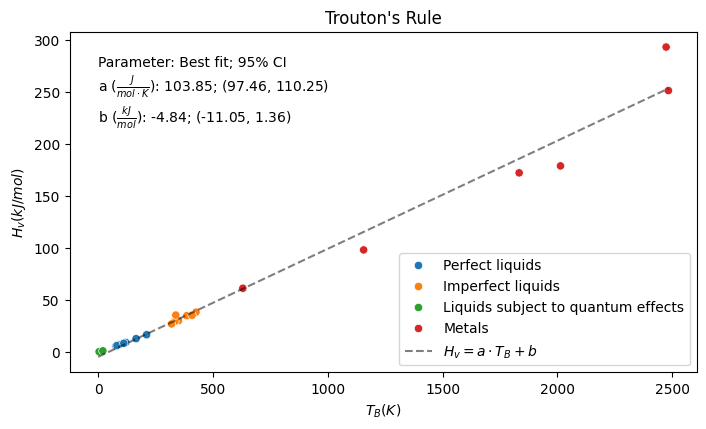

In [67]:
fig, ax = plt.subplots(figsize=(7, 4))
fig.tight_layout()

# plot with different colors by class
sns.scatterplot(df, ax=ax, x='T_B (K)', y='H_v (kJ/mol)', hue='Class')

# plot fitted line
x = np.linspace(0, df['T_B (K)'].max(), 2)
ax.plot(x, 
    slope_JmolK/1000*x+intercept_kJmol, # make sure units match 
    '--', 
    label=f"$H_v = a\\cdot T_B + b$",
    alpha=0.5,
    color='black'
)

# annotate CI
ax.text(0, 200, f"""Parameter: Best fit; 95% CI
a ($\\frac{{J}}{{mol\\cdot K}}$): {slope_JmolK:.2f}; ({slope_ci_JmolK[0]:.2f}, {slope_ci_JmolK[1]:.2f})
b ($\\frac{{kJ}}{{mol}}$): {intercept_kJmol:.2f}; ({intercept_ci_kJmol[0]:.2f}, {intercept_ci_kJmol[1]:.2f})
""")
ax.set_xlabel("$T_B (K)$")
ax.set_ylabel("$H_v (kJ/mol)$")
ax.set_title("Trouton's Rule")
ax.legend()
fig.savefig('homework-3-1/trouton.png', dpi=200, bbox_inches='tight')

## Interpret the slope and compare to Trouton's Rule

The slope can be interpreted as $\Delta S_v$. Using linear regression, we obtained a best fit with a slope of 103.85 $\frac{J}{mol\cdot K}$ and we are 95% confident that the slope falls between 97.46 and 110.25 $\frac{J}{mol\cdot K}$. We can perform hypothesis testing with the null hypothesis being that the true slope is 88 $\frac{J}{mol\cdot K}$ and $\alpha=0.5$. Since the 95% confidence interval of the slope does not contain 88 $\frac{J}{mol\cdot K}$, we can reject the null hypothesis. Therefore, we conclude with 95% confidence that for our data, $\Delta S_v \neq 88 \frac{J}{mol\cdot K}$.<br>
We see from the plot that the distribution of enthalpies over temperature is highly uneven, with most points clustered at low temperatures but a few points fluctuating a lot at high temperatures. Linear regression minimizes residual sum of squares, which would be affected more by those few datapoints at the high temperature end. This could explain why our result deviates from Trouton's rule.<br>
We can perform a similar test with the intercept, with the null hypothesis being the true intercept is 0 and $\alpha=0.5$. This time its 95% confidence interval includes 0, therefore we cannot reject the null hypothesis. This is consistent with theoretical thermodynamics predictions. Under constant pressure, $\Delta G_v = \Delta H_v - T\Delta S_v = 0$ since vaporization is reversible. Therefore, $\Delta H_v = \Delta S_v \times T$. This predicts a 0 intercept.